## Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import io
from PIL import Image

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
%load_ext tensorboard

import os
import matplotlib.pylab as plt
import numpy as np
import math
import datetime
import pandas as pd

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.9.1


# Examples of Keras callback applications
[Callback](https://keras.io/api/callbacks/)

In [2]:
# Download and prepare the horses or humans dataset

# horses_or_humans 3.0.0 has already been downloaded for you
path = "./tensorflow_datasets"
splits, info = tfds.load('horses_or_humans', data_dir=path, as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'])

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes


In [3]:
num_examples

1027

(300, 300, 3)
()


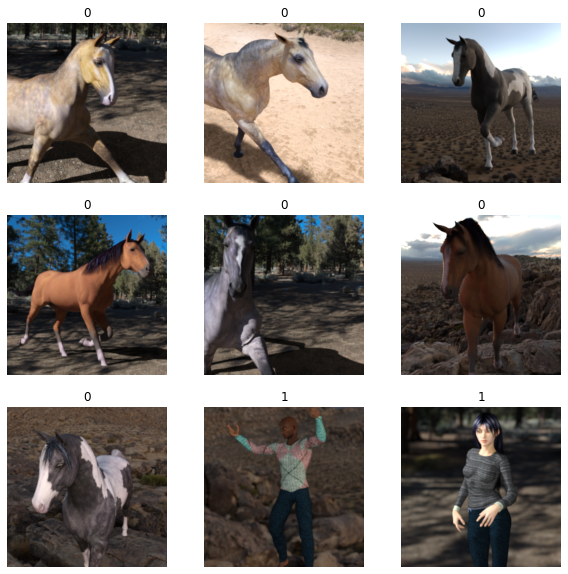

In [4]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_examples.take(1):
#     plt.imshow(images.numpy().astype("uint8"))
#     #plt.title(class_names[labels[i]])
#     plt.axis("off")
    
plt.figure(figsize=(10, 10))
i = 0
for images, labels in train_examples.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    i = i + 1
    plt.title(labels.numpy().astype("uint8"))
    plt.axis("off")
    
print(images.shape)
print(labels.shape)


In [5]:
len(list(test_examples))

256

In [6]:
len(list(train_examples))

822

In [7]:
len(list(validation_examples))

205

In [8]:
SIZE = 150 #@param {type:"slider", min:64, max:300, step:1}
IMAGE_SIZE = (SIZE, SIZE)

In [9]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

In [10]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [11]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [12]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 150, 150, 3])

In [13]:
input_shape=IMAGE_SIZE + (3,)
input_shape

(150, 150, 3)

In [14]:
def build_model(dense_units, input_shape=IMAGE_SIZE + (3,)):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(dense_units, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')
  ])
  return model

## [TensorBoard](https://keras.io/api/callbacks/tensorboard/)

Enable visualizations for TensorBoard.

In [15]:
!rm -rf logs

In [16]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model.fit(train_batches, 
          epochs=10, 
          validation_data=validation_batches, 
          callbacks=[tensorboard_callback])

Epoch 1/10
26/26 [==============================] - 5s 182ms/step - loss: 0.6818 - accuracy: 0.5900 - val_loss: 0.6337 - val_accuracy: 0.7561
Epoch 2/10
26/26 [==============================] - 5s 186ms/step - loss: 0.6275 - accuracy: 0.6606 - val_loss: 0.6019 - val_accuracy: 0.6049
Epoch 3/10
26/26 [==============================] - 4s 172ms/step - loss: 0.5515 - accuracy: 0.7360 - val_loss: 0.7079 - val_accuracy: 0.5220
Epoch 4/10
26/26 [==============================] - 4s 161ms/step - loss: 0.5412 - accuracy: 0.7445 - val_loss: 0.5092 - val_accuracy: 0.7268
Epoch 5/10
26/26 [==============================] - 4s 167ms/step - loss: 0.4636 - accuracy: 0.7956 - val_loss: 0.4047 - val_accuracy: 0.8878
Epoch 6/10
26/26 [==============================] - 4s 171ms/step - loss: 0.4244 - accuracy: 0.8175 - val_loss: 0.3356 - val_accuracy: 0.9463
Epoch 7/10
26/26 [==============================] - 4s 169ms/step - loss: 0.3111 - accuracy: 0.9148 - val_loss: 0.3140 - val_accuracy: 0.8780
Epoch 

In [17]:
%tensorboard --logdir logs

/opt/anaconda3/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


<IPython.core.display.Javascript object>

## [Model Checkpoint](https://keras.io/api/callbacks/model_checkpoint/)

Callback to save the Keras model or model weights at some frequency.

In [18]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', verbose=1),
          ])

Epoch 1/5

Epoch 1: saving model to weights.01-0.63.h5
26/26 - 5s - loss: 0.6867 - accuracy: 0.5754 - val_loss: 0.6269 - val_accuracy: 0.7024 - 5s/epoch - 186ms/step
Epoch 2/5

Epoch 2: saving model to weights.02-0.58.h5
26/26 - 4s - loss: 0.6060 - accuracy: 0.6934 - val_loss: 0.5765 - val_accuracy: 0.7512 - 4s/epoch - 173ms/step
Epoch 3/5

Epoch 3: saving model to weights.03-0.53.h5
26/26 - 5s - loss: 0.5813 - accuracy: 0.7409 - val_loss: 0.5293 - val_accuracy: 0.8000 - 5s/epoch - 173ms/step
Epoch 4/5

Epoch 4: saving model to weights.04-0.55.h5
26/26 - 4s - loss: 0.5306 - accuracy: 0.7640 - val_loss: 0.5497 - val_accuracy: 0.6683 - 4s/epoch - 164ms/step
Epoch 5/5

Epoch 5: saving model to weights.05-0.69.h5
26/26 - 5s - loss: 0.4489 - accuracy: 0.8285 - val_loss: 0.6883 - val_accuracy: 0.5317 - 5s/epoch - 174ms/step


In [19]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=1, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('saved_model', verbose=1)
          ])


Epoch 1: saving model to saved_model


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


26/26 - 6s - loss: 0.6754 - accuracy: 0.6046 - val_loss: 0.6779 - val_accuracy: 0.5024 - 6s/epoch - 232ms/step


In [20]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=2, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('model.h5', verbose=1)
          ])

Epoch 1/2

Epoch 1: saving model to model.h5
26/26 - 5s - loss: 0.6733 - accuracy: 0.5693 - val_loss: 0.6455 - val_accuracy: 0.6829 - 5s/epoch - 196ms/step
Epoch 2/2

Epoch 2: saving model to model.h5
26/26 - 5s - loss: 0.6057 - accuracy: 0.6934 - val_loss: 0.6107 - val_accuracy: 0.6195 - 5s/epoch - 181ms/step


## [Early stopping](https://keras.io/api/callbacks/early_stopping/)

Stop training when a monitored metric has stopped improving.

In [21]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[EarlyStopping(
              patience=3,
              min_delta=0.05,
              baseline=0.8,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)
          ])

Epoch 1/50
26/26 - 5s - loss: 0.6574 - accuracy: 0.5912 - val_loss: 0.6297 - val_accuracy: 0.7512 - 5s/epoch - 188ms/step
Epoch 2/50
26/26 - 5s - loss: 0.6100 - accuracy: 0.6727 - val_loss: 0.6500 - val_accuracy: 0.5512 - 5s/epoch - 187ms/step
Epoch 3/50
26/26 - 5s - loss: 0.5781 - accuracy: 0.7141 - val_loss: 0.5276 - val_accuracy: 0.8049 - 5s/epoch - 178ms/step
Epoch 4/50
26/26 - 5s - loss: 0.5196 - accuracy: 0.7713 - val_loss: 0.4653 - val_accuracy: 0.7902 - 5s/epoch - 188ms/step
Epoch 5/50
26/26 - 4s - loss: 0.4512 - accuracy: 0.8114 - val_loss: 0.4754 - val_accuracy: 0.7902 - 4s/epoch - 173ms/step
Epoch 6/50
26/26 - 5s - loss: 0.4008 - accuracy: 0.8321 - val_loss: 0.3861 - val_accuracy: 0.8780 - 5s/epoch - 178ms/step
Epoch 7/50
26/26 - 5s - loss: 0.3513 - accuracy: 0.8577 - val_loss: 0.6169 - val_accuracy: 0.6537 - 5s/epoch - 183ms/step
Epoch 8/50
26/26 - 5s - loss: 0.3536 - accuracy: 0.8589 - val_loss: 0.2802 - val_accuracy: 0.9073 - 5s/epoch - 194ms/step
Epoch 9/50
26/26 - 5s - 

## [CSV Logger](https://keras.io/api/callbacks/csv_logger/)

Callback that streams epoch results to a CSV file.

In [22]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
csv_file = 'training.csv'

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[CSVLogger(csv_file)
          ])

Epoch 1/5
26/26 [==============================] - 5s 190ms/step - loss: 0.6562 - accuracy: 0.6423 - val_loss: 0.6535 - val_accuracy: 0.5317
Epoch 2/5
26/26 [==============================] - 5s 177ms/step - loss: 0.6006 - accuracy: 0.7287 - val_loss: 0.5680 - val_accuracy: 0.7561
Epoch 3/5
26/26 [==============================] - 5s 174ms/step - loss: 0.5400 - accuracy: 0.7567 - val_loss: 0.4852 - val_accuracy: 0.8293
Epoch 4/5
26/26 [==============================] - 5s 184ms/step - loss: 0.4760 - accuracy: 0.7993 - val_loss: 0.5157 - val_accuracy: 0.7171
Epoch 5/5
26/26 [==============================] - 4s 167ms/step - loss: 0.4173 - accuracy: 0.8224 - val_loss: 0.3382 - val_accuracy: 0.9024


In [23]:
pd.read_csv(csv_file).head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.642336,0.656156,0.531707,0.653505
1,1,0.728710,0.600612,0.756098,0.568024
2,2,0.756691,0.539983,0.829268,0.485231
3,3,0.799270,0.476049,0.717073,0.515669
4,4,0.822384,0.417311,0.902439,0.338159


## [Learning Rate Scheduler](https://keras.io/api/callbacks/learning_rate_scheduler/)

Updates the learning rate during training.

In [24]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
def step_decay(epoch):
	initial_lr = 0.01
	drop = 0.5
	epochs_drop = 1
	lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lr

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[LearningRateScheduler(step_decay, verbose=1),
                    TensorBoard(log_dir='./log_dir')])


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/5
26/26 [==============================] - 5s 177ms/step - loss: 0.6804 - accuracy: 0.5414 - val_loss: 0.6915 - val_accuracy: 0.4439 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.0025.
Epoch 2/5
26/26 [==============================] - 4s 170ms/step - loss: 0.6597 - accuracy: 0.5791 - val_loss: 0.6755 - val_accuracy: 0.4927 - lr: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.00125.
Epoch 3/5
26/26 [==============================] - 4s 168ms/step - loss: 0.6495 - accuracy: 0.6107 - val_loss: 0.6677 - val_accuracy: 0.5171 - lr: 0.0012

Epoch 4: LearningRateScheduler setting learning rate to 0.000625.
Epoch 4/5
26/26 [==============================] - 4s 168ms/step - loss: 0.6438 - accuracy: 0.6192 - val_loss: 0.6639 - val_accuracy: 0.5268 - lr: 6.2500e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0003125.
Epoch 5/5
26/26 [==============================] -

## [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

Reduce learning rate when a metric has stopped improving.

In [25]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          callbacks=[ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.2, verbose=1,
                                       patience=1, min_lr=0.001),
                     TensorBoard(log_dir='./log_dir')])

Epoch 1/50
26/26 [==============================] - 5s 179ms/step - loss: 0.6755 - accuracy: 0.5596 - val_loss: 0.6692 - val_accuracy: 0.5707 - lr: 0.0100
Epoch 2/50
26/26 [==============================] - 5s 190ms/step - loss: 0.6373 - accuracy: 0.6946 - val_loss: 0.6391 - val_accuracy: 0.5902 - lr: 0.0100
Epoch 3/50
26/26 [==============================] - 5s 175ms/step - loss: 0.5893 - accuracy: 0.7348 - val_loss: 0.5485 - val_accuracy: 0.8244 - lr: 0.0100
Epoch 4/50
26/26 [==============================] - 5s 174ms/step - loss: 0.5013 - accuracy: 0.8102 - val_loss: 0.4688 - val_accuracy: 0.8000 - lr: 0.0100
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.8114
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
26/26 [==============================] - 5s 180ms/step - loss: 0.4385 - accuracy: 0.8114 - val_loss: 0.4982 - val_accuracy: 0.7268 - lr: 0.0100
Epoch 6/50
26/26 [==============================] - 5s 181ms/step 